In [106]:
import sys
sys.path.append('../')
from functools import partial
import pandas as pd
import seaborn as sns; sns.set(style='darkgrid', context='talk')
from matplotlib import pyplot as plt

id_columns = ['architecture', 'task', 'kind', 'source', 'layer']
bench = 'majajhong2015'
pooling = True
data = pd.read_csv(f'../results/dimusage|benchmark:{bench}|pooling:{pooling}.csv')

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu',
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu',
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu',
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

# Build set of outliers
data_ed = pd.merge(pd.read_csv(f'../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:{pooling}.csv'),
                   pd.read_csv(f'../results/eigmetrics|dataset:imagenet|pooling:{pooling}|grayscale:False.csv'),
                   on=id_columns)
data_outliers = pd.merge(pd.read_csv(f'../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                         pd.read_csv(f'../results/eigmetrics|dataset:imagenet|pooling:{pooling}|grayscale:False.csv'),
                         on=id_columns)
data_ed.loc[:, 'layer'] = data_ed['layer'].replace(tf_to_pt_layer_map)
data_outliers.loc[:, 'layer'] = data_outliers['layer'].replace(tf_to_pt_layer_map)
performant = (data_outliers['score'] > 0.43)
outliers = performant & (data_outliers['effective dimensionality'] < 10)
performant = data_outliers[performant][id_columns].reset_index(drop=True)
outliers = data_outliers[outliers][id_columns].reset_index(drop=True)

def isin_group(groupdf, row):
    row = row[id_columns]
    return (row == groupdf).all(axis='columns').sum().astype(bool)

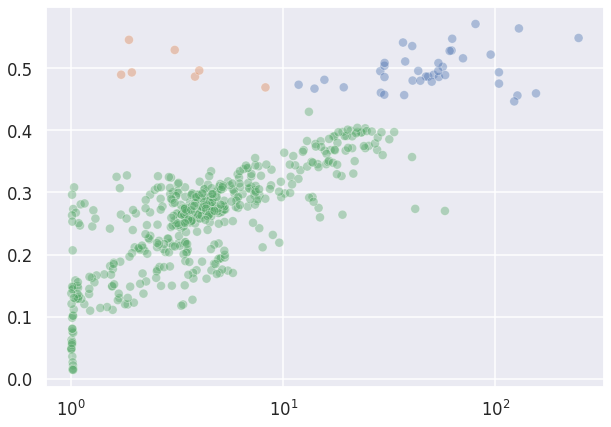

In [107]:
results = data_outliers.copy()
results['group'] = results.apply(partial(isin_group, outliers), axis='columns').astype(int) + \
                   results.apply(partial(isin_group, performant), axis='columns').astype(int)
results['group'] = results.group.astype(str)

_, ax = plt.subplots(figsize=(10, 7))
c = sns.color_palette()
sns.scatterplot(data=results, x='effective dimensionality', y='score', hue='group',
                palette=[c[2], c[0], c[1]], alpha=0.4, ax=ax)
ax.set(xlabel=None, ylabel=None, xscale='log')
ax.legend().remove()

plt.show()

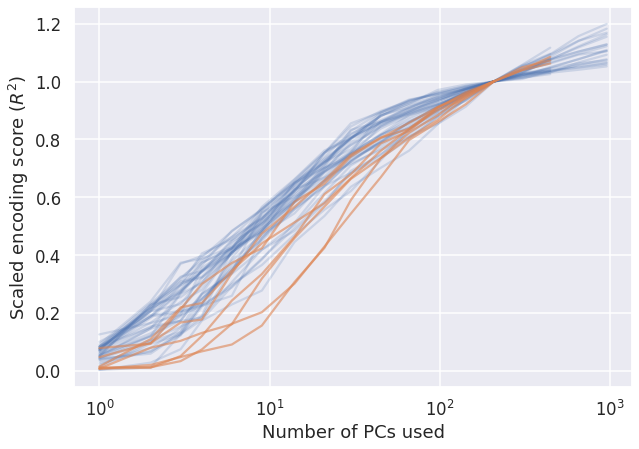

In [109]:
scaled = True
norm_pc = 207

results = data.copy()
results = results[results.apply(partial(isin_group, performant), axis='columns')]
results['outlier'] = results.apply(partial(isin_group, outliers), axis='columns')
results['id'] = results[id_columns].sum(axis='columns')

if scaled:
    scaled_scores = results.groupby(id_columns).apply(lambda x: x.scores / x[x.num_pcs == norm_pc].scores.item())
    scaled_scores = scaled_scores.reset_index(id_columns, drop=True)
    results['scaled_scores'] = scaled_scores

_, ax = plt.subplots(figsize=(10, 7))
y = 'scaled_scores' if scaled else 'scores'
ylabel = r'Scaled encoding score ($R^2$)' if scaled else r'Encoding score ($R^2$)'
sns.lineplot(data=results[~results.outlier], x='num_pcs', y=y,
             units='id', estimator=None, alpha=0.2, ax=ax)
sns.lineplot(data=results[results.outlier], x='num_pcs', y=y,
             units='id', estimator=None, alpha=0.6, ax=ax)
ax.set(xlabel='Number of PCs used', ylabel=ylabel, xscale='log')

plt.show()